In [28]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
import copy


def create_grid(size, neutrons):
    
    """ Create a grid with boundary cells.
    The 'size' should be odd to ensure a central cell for the neutron.
    """
    
    if size % 2 == 0:
        size += 1  # Adjust to odd size
   
    grid = np.zeros((size + 2, size + 2), dtype=int) 
    
    centre = len(grid) // 2   # adds default neutron at the centre
    grid[centre, centre] = neutrons #number(s) of starting neutrons
    
    '''CheckerBoard Fuel & Moderator'''
    
    #fm_pattern = np.zeros_like(grid)  # Fuel Cells are assigned, 1, and Moderators, 0.
    
    #fm_pattern[1::2, 1::2] = 1  
    #fm_pattern[2::2, 2::2] = 1
    #fm_pattern[::,-1] = 0
    #fm_pattern[-1,::]= 0 
    
    ''' CircleBoard Fuel & Moderator  '''
    
    fm_pattern = np.zeros_like(grid)
    ring_width = 2
    
    for i in range(len(grid)):
        for j in range(len(grid)):
            dist = np.sqrt((i - centre)**2 + (j - centre)**2)
            
            if int(dist // ring_width) % 2 == 0:
                fm_pattern[i, j] = 1  
            else:
                fm_pattern[i, j] = 0  

    # Ensure boundary cells are moderators
    fm_pattern[0, :] = fm_pattern[-1, :] = fm_pattern[:, 0] = fm_pattern[:, -1] = 0

    
    
    
    '''Creating and Labelling the Neutron Speed: Fast or Slow Grid.'''
    
    ns_grid = np.empty((size + 2, size + 2), dtype=object)
    
    for i in range(1, len(ns_grid) - 1):
            for j in range(1, len(ns_grid[0]) - 1):
                ns_grid[i, j] = {'slow': 0, 'fast': 0} 
    

    speeds = random.choices(['slow', 'fast'],[0,1], k=neutrons)  ###try all slow and then all fast -----> this introduces a lot of randomness, try to keep the same . justjeep simple for consistenty replication
    for speed in speeds:
        ns_grid[centre, centre][speed] += 1

    return grid, fm_pattern, ns_grid


def perform_random_walk(grid, fm_pattern, ns_grid, row, col):
    moves = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    move = random.choice(moves)

    new_row, new_col = row + move[0], col + move[1]

    if 0 < new_row < len(grid) - 1 and 0 < new_col < len(grid[0]) - 1:
        
        return new_row, new_col
    
    return None, None  #if moved cell is out of bounds


def verify_neutron_counts_for_cell(grid, ns_grid, row, col):
    
    if row is None or col is None:
        return True 
    
    if 0 < row < grid.shape[0] - 1 and 0 < col < grid.shape[1] - 1:
        total_neutrons = grid[row, col]
        if ns_grid[row, col] is not None:
            neutron_counts = ns_grid[row, col]['slow'] + ns_grid[row, col]['fast']
        else:
            neutron_counts = 0 
        
        if total_neutrons != neutron_counts:
            print(f"Mismatch at ({row}, {col}): grid={total_neutrons}, ns_grid={neutron_counts}")
            return False
    return True


def simulate_neutron_reactions(grid, fm_pattern, ns_grid, N, debug, p_fission):
    
    initial_n = np.sum(grid)
    amounts_recorded = [initial_n]
    
    amounts_recorded_slow = [sum(cell['slow'] for row in ns_grid[1:-1, 1:-1] for cell in row)]
    amounts_recorded_fast = [sum(cell['fast'] for row in ns_grid[1:-1, 1:-1] for cell in row)]
    
    fission_counts= []
    
    neutron_leaks = []
    
    
    #fission occurred per time cycle apended
    # slow and fast per unit time appended
    #fission  neutrons occurred per time cycle apended
    
    
    for iteration in range(N - 1):
        
        
        iteration_grid = np.zeros_like(grid)
        
        neutron_grid = np.empty((size + 2, size + 2), dtype=object)
        
        for i in range(1, len(neutron_grid) - 1):
                for j in range(1, len(neutron_grid[0]) - 1):
                    neutron_grid[i, j] = {'slow': 0, 'fast': 0} 
                    
        fission_counts_this_step = 0
        neutron_leaks_this_step = 0
            
        for row in range(1, len(grid) - 1):
            for col in range(1, len(grid[0]) - 1):
                
                while grid[row, col] > 0: # As long until the cell has more than zero neutrons...
                
                    new_row, new_col = perform_random_walk(grid, fm_pattern, ns_grid, row, col)
                    
                    statement = ''
                    selected_outcome = ''
                    
                    
                    if new_row is not None and new_col is not None: 
                        
                        if ns_grid[row, col]['slow'] > 0 and fm_pattern[new_row, new_col] == 1:
                            
                            absorption_prob = 0.0001
                            nothing_prob = 1 - (absorption_prob + p_fission)
                            
                            outcomes_sf = ['absorption', 'fission', 'nothing']
                            probabilities_sf = [absorption_prob, p_fission, nothing_prob] #[0.05, 0.40, 0.55]
                            selected_outcome_sf = random.choices(outcomes_sf, probabilities_sf, k=1)[0]
                            statement = f"A slow neutron has been moved to this fuel cell, and underwent {selected_outcome_sf}"
                            
                            # Absorption
                            if selected_outcome_sf == 'absorption':
                                # Neutron is absorbed: remove slow neutron from grids and nothing else...
                                grid[row, col] -= 1
                                ns_grid[row, col]['slow'] -= 1
                                
                            #Triggers Fission
                            elif selected_outcome_sf == 'fission':
                                ###establish prob outcomes for 2 or 3 neutron fission
                                outcome_fission_neutrons = [2, 3]
                                probabilities_fission_neutrons = [0.7, 0.3]
                                fission_amount = random.choices(outcome_fission_neutrons, probabilities_fission_neutrons, k=1)[0]
                                
                                fission_counts_this_step += fission_amount
                                
                                iteration_grid[new_row, new_col] += fission_amount # all neutrons are moved to the new cell & recorded on ite._grid
                                grid[row, col] -= 1
                                # The speed grid is updated such that the slow neutron has left the og cell.
                                neutron_grid[new_row, new_col]['fast'] += fission_amount #new neutrons are all fast. could add prob distribution also
                                ns_grid[row,col]['slow'] -= 1
                                
                            # Nothing. Slow Neutron does not trigger Fission but is moved.
                            elif selected_outcome_sf == 'nothing':
                                iteration_grid[new_row, new_col] += 1
                                grid[row, col] -= 1
                                
                                neutron_grid[new_row, new_col]['slow'] += 1
                                ns_grid[row, col]['slow'] -= 1
                        
                            #verify_neutron_counts_for_cell(grid, ns_grid, row, col)
                            #verify_neutron_counts_for_cell(grid, ns_grid, new_row, new_col)
                                
                            

                        elif ns_grid[row, col]['fast'] > 0 and fm_pattern[new_row, new_col] == 1:
                            
                            
                            outcomes_ff = ['absorption', 'nothing']
                            probabilities_ff = [0.0001,0.9999]
                            selected_outcome_ff = random.choices(outcomes_ff, probabilities_ff, k=1)[0]
                            statement = f"A fast neutron has been moved to this fuel cell, and underwent {selected_outcome_ff}"
                            
                            # Absorption
                            if selected_outcome_ff == 'absorption':
                                # Neutron is absorbed: remove fast neutron from grids and nothing else...
                                grid[row, col] -= 1
                                ns_grid[row, col]['fast'] -= 1
                                
                            # Nothing. Fast Neutron is moved to fuel cell.
                            elif selected_outcome_ff == 'nothing':
                                iteration_grid[new_row, new_col] += 1
                                grid[row, col] -= 1
                                neutron_grid[new_row, new_col]['fast'] += 1                     
                                ns_grid[row, col]['fast'] -= 1
                                
                            #verify_neutron_counts_for_cell(grid, ns_grid, row, col)
                            #verify_neutron_counts_for_cell(grid, ns_grid, new_row, new_col)
                            

                        elif ns_grid[row, col]['slow'] > 0 and fm_pattern[new_row, new_col] == 0:
        
                            
                            outcomes_sm = ['absorption', 'nothing']
                            probabilities_sm = [0.0001,0.9999] #[0.15, 0.85]
                            selected_outcome_sm = random.choices(outcomes_sm, probabilities_sm, k=1)[0]
                            statement = f"A Slow neutron has been moved to this Moderator cell, and underwent {selected_outcome_sm}"
                        
                            # Absorption
                            if selected_outcome_sm == 'absorption':
                                grid[row, col] -= 1
                                ns_grid[row, col]['slow'] -= 1
                                
                            # Nothing. Slow Neutron is moved to moderator cell.
                            elif selected_outcome_sm == 'nothing':
                                iteration_grid[new_row, new_col] += 1
                                grid[row, col] -= 1        
                                
                                neutron_grid[new_row, new_col]['slow'] += 1                      
                                ns_grid[row,col]['slow'] -= 1
                                
                            #verify_neutron_counts_for_cell(grid, ns_grid, row, col)
                            #verify_neutron_counts_for_cell(grid, ns_grid, new_row, new_col)
                        
    
                        elif ns_grid[row, col]['fast'] > 0 and fm_pattern[new_row, new_col] == 0:
        
                            
                            outcomes_fm = ['absorption', 'thermalisation']
                            probabilities_fm = [0.0001,0.9999]
                            selected_outcome_fm = random.choices(outcomes_fm, probabilities_fm, k=1)[0]
                            statement = f"A Fast neutron has been moved to this Moderator cell, and underwent {selected_outcome_fm}"
                            
                            # Absorption
                            if selected_outcome_fm == 'absorption':
                                grid[row, col] -= 1
                                ns_grid[row, col]['fast'] -= 1
                                
                            # Neutron is Thermalised or Nothing.
                            elif selected_outcome_fm == 'thermalisation':
                                iteration_grid[new_row, new_col] += 1
                                grid[row, col] -= 1
                                
                                outcome_neutron_speed = ['slow', 'fast']
                                probabilities_neutron_speed = [0.0800080008, 0.9199919992]
                                neutron_speed = random.choices(outcome_neutron_speed, probabilities_neutron_speed, k=1)[0]
                                
                                if neutron_speed == 'slow':
                                    neutron_grid[new_row, new_col]['slow'] += 1 
                                    ns_grid[row,col]['fast'] -= 1
                                    
                                elif neutron_speed == 'fast':
                                    neutron_grid[new_row, new_col]['fast'] += 1 
                                    ns_grid[row,col]['fast'] -= 1
                                    
                            #verify_neutron_counts_for_cell(grid, ns_grid, row, col)
                            #verify_neutron_counts_for_cell(grid, ns_grid, new_row, new_col)
                        
                        else:
                            pass


                    if new_row is None and new_col is None:
                        
                        statement = "A neutron has been leaked"
                        
                        neutron_leaks_this_step += 1
                        
                        if ns_grid[row, col]['slow'] > 0:
                            
                            grid[row,col] -= 1
                            ns_grid[row,col]['slow'] -= 1
                            
                        elif ns_grid[row, col]['fast'] > 0:
                            
                            grid[row,col] -= 1
                            ns_grid[row,col]['fast'] -= 1
                           
                        else:
                            pass
                        
                        #verify_neutron_counts_for_cell(grid, ns_grid, row, col)
                        #verify_neutron_counts_for_cell(grid, ns_grid, new_row, new_col)
                    
                    if debug:
                        print(f"The neutron underwent: {statement}")
                       
                    
        grid += iteration_grid
                
        for i in range(1, len(ns_grid) - 1):
            for j in range(1, len(ns_grid[i]) - 1):
                for key in ns_grid[i, j]:
                    ns_grid[i, j][key] = neutron_grid[i, j][key]
                    
        neutrons_now = np.sum(grid)
        amounts_recorded.append(neutrons_now)
        
        slow_neutrons_now = sum(cell['slow'] for row in ns_grid[1:-1, 1:-1] for cell in row)
        amounts_recorded_slow.append(slow_neutrons_now)
        
        fast_neutrons_now = sum(cell['fast'] for row in ns_grid[1:-1, 1:-1] for cell in row)
        amounts_recorded_fast.append(fast_neutrons_now)
        
        fission_counts.append(fission_counts_this_step)
        neutron_leaks.append(neutron_leaks_this_step)
        
        
        
        
        
        if debug:
            
            print(f"The iteration is {iteration}: \n {grid} \n\n\n ")
            #print(f"The iteration is {iteration}:{ns_grid}")
            
    
                        
    return grid, amounts_recorded, amounts_recorded_slow, amounts_recorded_fast, fission_counts, neutron_leaks





def run_simulation_with_animation_and_measure_comp_time(neutron_count, size, N, debug, debug_ani, p_fission):
    
    init_grid, init_fm, init_nspeed = create_grid(size, neutrons = neutron_count)
    
    start_time = time.time()
    updated_grid, amounts_recorded, s, f, nfission, nleaks = simulate_neutron_reactions(init_grid.copy(), init_fm.copy(), init_nspeed.copy(), N, debug = debug , p_fission = p_fission)
    end_time = time.time()
    
    computation_time = end_time - start_time
    
    #print(f"Simulation computation time: {computation_time} seconds")
    
    #print(updated_grid)
    
    if debug_ani:
        
        animation_grid = init_grid.copy()
        fig, ax = plt.subplots()
        img = ax.imshow(animation_grid, animated=True)
        
        def update_frame(frame, grid, fm, nspeed, img):
            if frame == 0:
                return img,
            new_grid = simulate_neutron_reactions(grid, init_fm, init_nspeed, 1, debug=False, p_fission = p_fission ) 
            img.set_array(new_grid)
            return img,
        
        ani = FuncAnimation(fig, update_frame, frames=range(N), fargs=(animation_grid, init_fm, init_nspeed, img), blit=True)
        plt.colorbar(img, ax=ax)
        ani.save('neutron_simulation.gif', writer='pillow', fps=1)
        plt.show()
        
    return computation_time, amounts_recorded, updated_grid, s, f, nfission, nleaks


####################################################################################################################################################################################################################################
################################################################################################################################################################################################################################################################################################################
####################################################################################################################################################################################################################################

N = 600
size = 17
neutron_count = 30
debug = False
p_fission = 0.9



grid ,fm ,ns = create_grid(size, neutron_count)
print(f"The reactor configuration: \n\n {fm} \n\n\n ")






ttime, a, g, s, f, nfissions, nleaks = run_simulation_with_animation_and_measure_comp_time(neutron_count = neutron_count, size = size, N = N,debug = debug, debug_ani = False, p_fission = p_fission)
print(f"Grid size: {size} \nThe number of steps are {N} \nStarting neutrons are {neutron_count}")
print(f"Computational time: {ttime:.3f} seconds for simulation")
print(f"\n\nFinal Grid after {N} steps:\n\n {g}")
print(f"amounts of neutrons: {a}")
print(f"amounts of slow neutrons: {s}")
print(f"amounts of fast neutrons: {f}")
print(f"amount of fission neutrons: {nfissions}")
print(f"amount of neutron leaks: {nleaks}")

################################################################################################################################################################################################################################################################################################################
####################################################################################################################################################################################################################################
####################################################################################################################################################################################################################################
########## 


The reactor configuration: 

 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
 [0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
 [0 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0]
 [0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0]
 [0 1 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 1 0]
 [0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0]
 [0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0]
 [0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0]
 [0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0]
 [0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0]
 [0 1 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 1 0]
 [0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0]
 [0 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
 [0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]] 


 
Grid size: 17 
The number of steps are 600 
Starting neutrons are 30
Computational time: 238.358 seconds for simulation


Final Grid after 600 steps:

 [[   0    0    0    0    0    0  

# Neutron Count Evolution

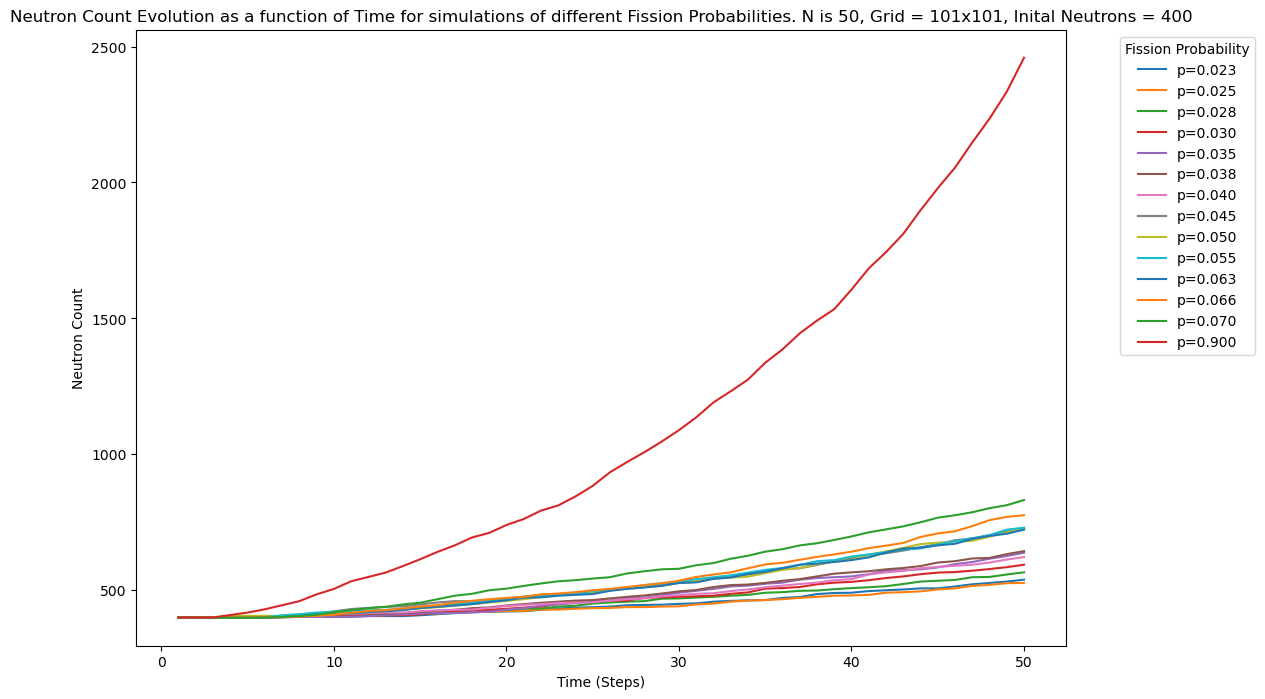

In [13]:
'''Neutron count Evolution as a function of Time for different Fission Probabilities'''



N = 50
size = 101
neutron_count = 400
debug = False

fission_probs = [0.023,0.025,0.028,0.030,0.035,0.038,0.04,0.045,0.050,0.055,0.063,0.066,0.070, 0.9]




plt.figure(figsize=(12, 8))

for p in fission_probs:
    
    ttime, n_amounts_recorded, g, s, f, nfission, nleaks = run_simulation_with_animation_and_measure_comp_time(neutron_count = neutron_count, size = size, N = N, debug = debug, debug_ani = False, p_fission = p)
    time_steps = np.linspace(1, N, N)
    plt.plot(time_steps, n_amounts_recorded, label = f"p={p:.3f}")
    
    
plt.xlabel('Time (Steps)')
plt.ylabel('Neutron Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Fission Probability")
plt.title(f'Neutron Count Evolution as a function of Time for simulations of different Fission Probabilities. N is {N}, Grid = {size}x{size}, Inital Neutrons = {neutron_count}')

plt.show()








# Neutron Count Evolution (Log)

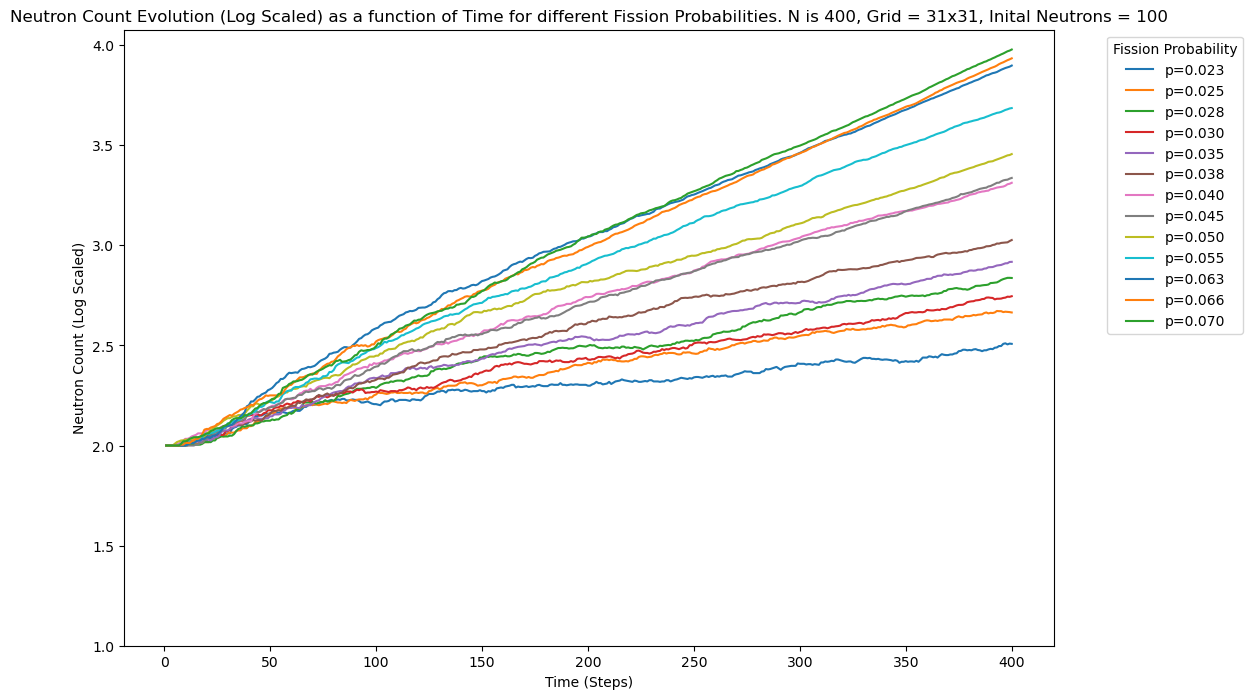

In [534]:
'''Neutron count (log scaled) as a function of time for different fission probabilities'''



N = 400
size = 31
neutron_count = 100
debug = False


fission_probs = [0.023,0.025,0.028,0.030,0.035,0.038,0.04,0.045,0.050,0.055,0.063,0.066,0.070]
#fission_probs = np.linspace(0.1, 1.0, 10)


plt.figure(figsize=(12, 8))

for p in fission_probs:
    
    ttime, n_amounts_recorded, g, s, f, nfission, nleaks = run_simulation_with_animation_and_measure_comp_time(neutron_count = neutron_count, size = size, N = N, debug = debug, debug_ani = False, p_fission = p)
    time_steps = np.linspace(1, N, N)
    log_n_amounts_recorded = np.log10(n_amounts_recorded)
    plt.plot(time_steps, log_n_amounts_recorded, label = f"p={p:.3f}")
    
    
plt.xlabel('Time (Steps)')
plt.ylabel('Neutron Count (Log Scaled)')
plt.ylim(bottom=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Fission Probability")
plt.title(f'Neutron Count Evolution (Log Scaled) as a function of Time for different Fission Probabilities. N is {N}, Grid = {size}x{size}, Inital Neutrons = {neutron_count}')

plt.show()



# notice different rate segments here


# add all the montecarlo siimulations and take averages




# pick a configuration and then study different parameter modifications....

#grid size to fission relation

#k ratio evoltion current/previous critical  =1 


# Slow & Fast Neutron Count Evolution

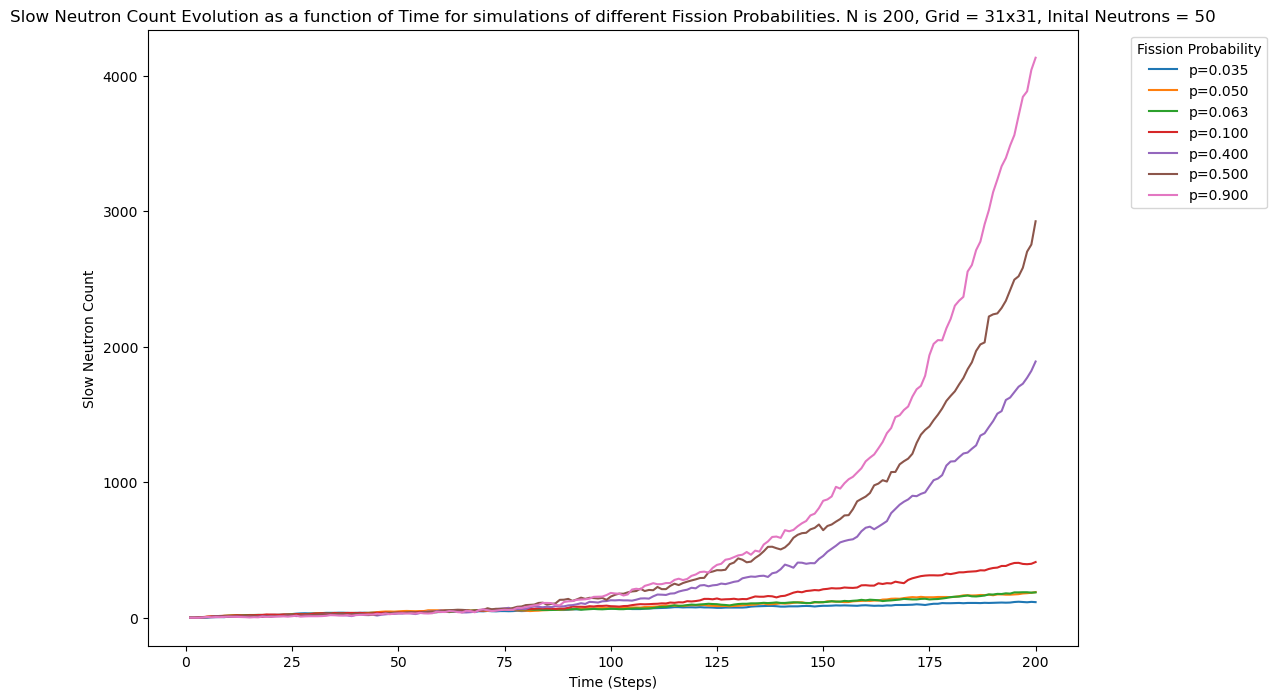

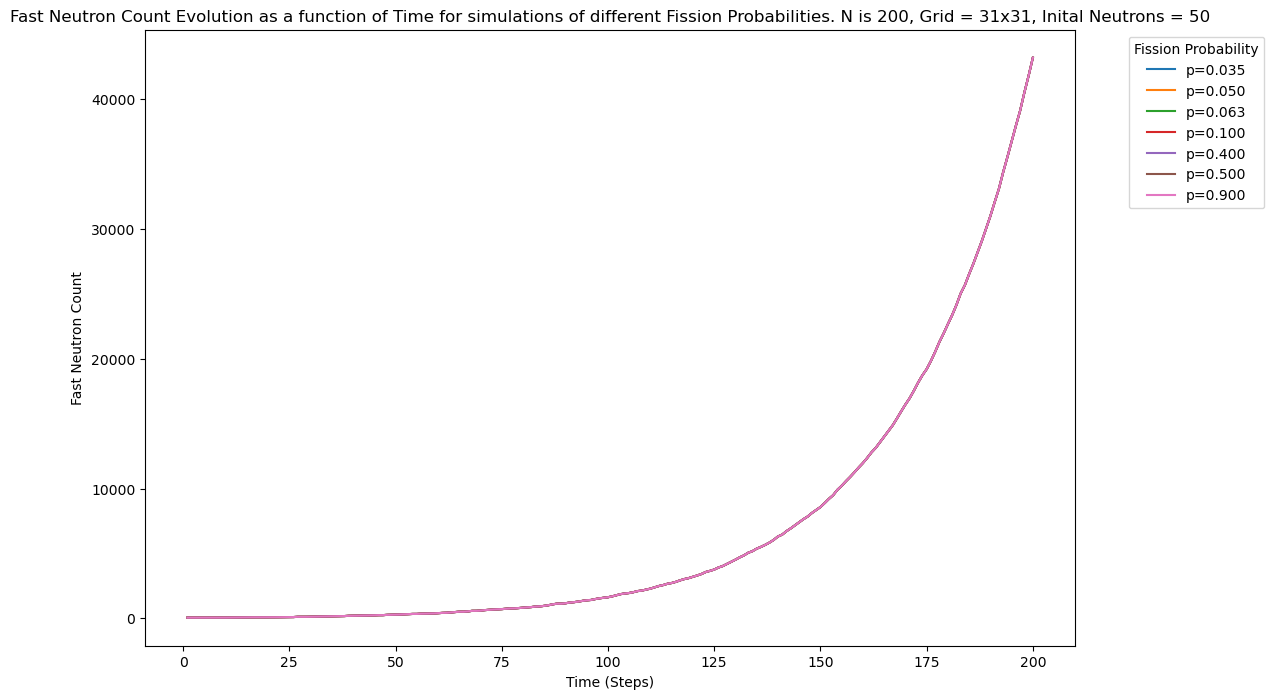

In [524]:
'''Slow and Fast Neutron count Evolution as a function of Time for different Fission Probabilities'''



N = 400
size = 31
neutron_count = 100
debug = False

fission_probs = [0.035,0.050,0.063,0.1,0.4,0.5,0.9]




plt.figure(figsize=(12, 8))

for p in fission_probs:
    
    ttime, n_amounts_recorded, g, s, f, nfission, nleaks = run_simulation_with_animation_and_measure_comp_time(neutron_count = neutron_count, size = size, N = N, debug = debug, debug_ani = False, p_fission = p)
    time_steps = np.linspace(1, N, N)
    plt.plot(time_steps, s, label = f"p={p:.3f}")
    
    
plt.xlabel('Time (Steps)')
plt.ylabel('Slow Neutron Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Fission Probability")
plt.title(f'Slow Neutron Count Evolution as a function of Time for simulations of different Fission Probabilities. N is {N}, Grid = {size}x{size}, Inital Neutrons = {neutron_count}')

plt.show()

plt.figure(figsize=(12, 8))

for p in fission_probs:
    
    plt.plot(time_steps, f, label = f"p={p:.3f}")
    
    
plt.xlabel('Time (Steps)')
plt.ylabel('Fast Neutron Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Fission Probability")
plt.title(f'Fast Neutron Count Evolution as a function of Time for simulations of different Fission Probabilities. N is {N}, Grid = {size}x{size}, Inital Neutrons = {neutron_count}')

plt.show()





# Fission Neutrons & Leakages Evolution

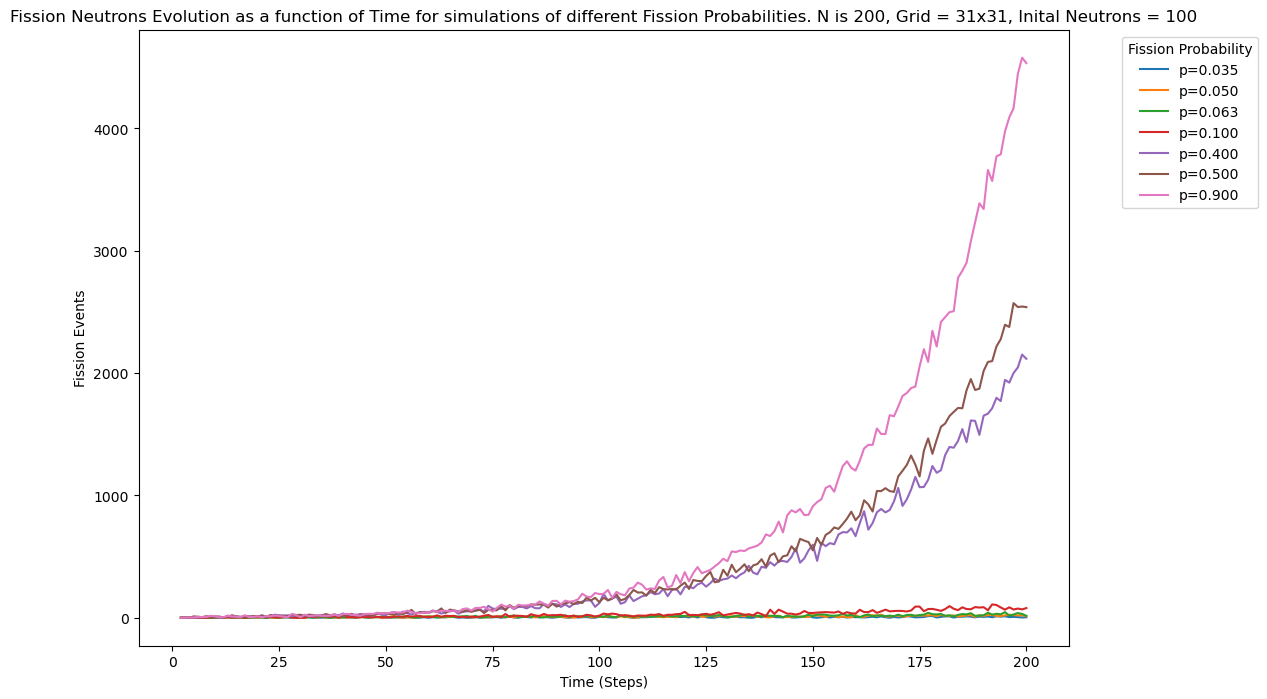

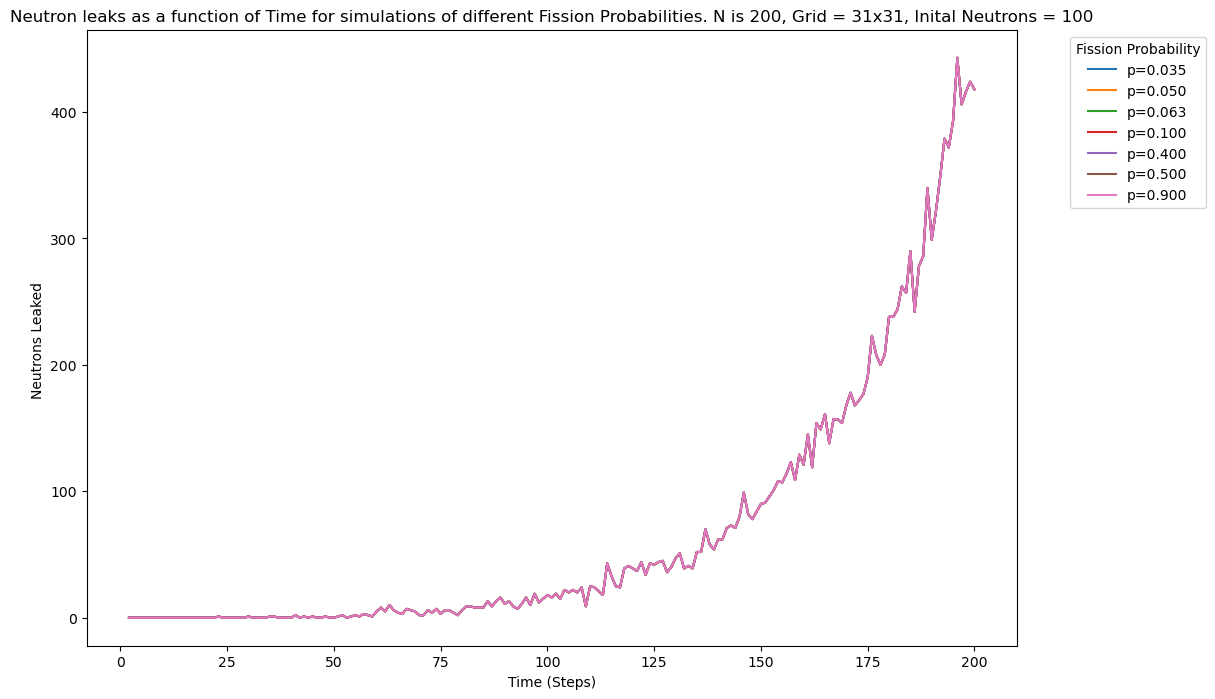

In [526]:
'''Fission Neutrons created as a function of Time for different Fission Probabilities'''



N = 200
size = 31
neutron_count = 100
debug = False

fission_probs = [0.035,0.050,0.063,0.1,0.4,0.5,0.9]




plt.figure(figsize=(12, 8))

for p in fission_probs:
    
    ttime, n_amounts_recorded, g, s, f, nfission, nleaks = run_simulation_with_animation_and_measure_comp_time(neutron_count = neutron_count, size = size, N = N, debug = debug, debug_ani = False, p_fission = p)
    
    time_steps = np.linspace(2, N, N-1)
    
    plt.plot(time_steps, nfission, label = f"p={p:.3f}")
    
    
plt.xlabel('Time (Steps)')
plt.ylabel('Fission Events')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Fission Probability")
plt.title(f'Fission Neutrons Evolution as a function of Time for simulations of different Fission Probabilities. N is {N}, Grid = {size}x{size}, Inital Neutrons = {neutron_count}')

plt.show()


'''Neutrons leaked as a function of Time for different Fission Probabilities'''


plt.figure(figsize=(12, 8))

for p in fission_probs:
    
    plt.plot(time_steps, nleaks, label = f"p={p:.3f}")
    
    
plt.xlabel('Time (Steps)')
plt.ylabel('Neutrons Leaked ')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Fission Probability")
plt.title(f'Neutron leaks as a function of Time for simulations of different Fission Probabilities. N is {N}, Grid = {size}x{size}, Inital Neutrons = {neutron_count}')

plt.show()















# Fine-Tuning

## Final Neutron counts for different parameter shiftings....
- final neutron vs grid size simulations
- final neutron vs simulation Ns
- final neutron vs starting neutron simulations

## total neutron counts - after each grid RW - over time (evolution) 

- for the criticality fprobability configuration

- with each RW point averaged from multiple montecarlo runs i.e 5
- this runs the function 5 time, appends the amounts and averages them, the corresponding RW values input the plot
- add the error bars as the max and min for each point
- with large enough N for each simulation
- for the log scale aswell

## total count-types of each RW - over time

- for the criticality fprobability

- the composition of fissions, leaks as compared to total neutrons over time:
- neutron counts - of each RW 
- fission-neutron counts - of each RW 
- neutron leak counts - of each RW 
- this shows the composition of fissions, leaks as compared to total neutrons for each N

- the compositions should be obtained from the same simulation sample execution
- try run many simulation samples i.e 10 and use the averages of the points to plot, including error bars


- taking the MC average would require doing 5x for each of the simulations say 5 x 400 = 2000 times longer 
- just take the averages deviations from 10 or 20 distributed simulations and fill the rest with same errors bars


### - parallel plot plus the kfactor plot, same but in composition percentages:
- shows how the compositions evolve over time for the same simulation configuration
- take the average error bars from the previous one to compute the current ones
- kfactor is the amount of neutrons now/previous 



# Reactivity

## Percentage compositions for final counts - vs different simulations of different N 

- real montecarlo, comp time high

- shows how the reactor dynamics is affected for higher N simulation runs. 
- taking the MC average would require doing 5x for each of the simulations say 5 x 400 = 2000 times longer 
- just take the average deviations from 10 or 20 distributed simulations and fill the rest with same errors bars
- for the kplot take the average kvalues

- these in the same plot:
- final fission-neutron counts
- final neutron leak counts
- average k values for different simulation of different N

## Average kvalue & compositions - vs different simulations grid sizes

- compt time high

- this will show the relationship in achieving criticality when the grid size is being changed
- essentially relates to the k-factor and how as grid size increases: more leakeages but even more neutron fissions

- if computing allows try different k graphs for different N sizes within function of gridsize range


# Configurations

## Average kvalue - vs different simulations grid sizes - for different grid configurations




# Final Neutron Count as a function of Fission Probabilities (Monte Carlo)

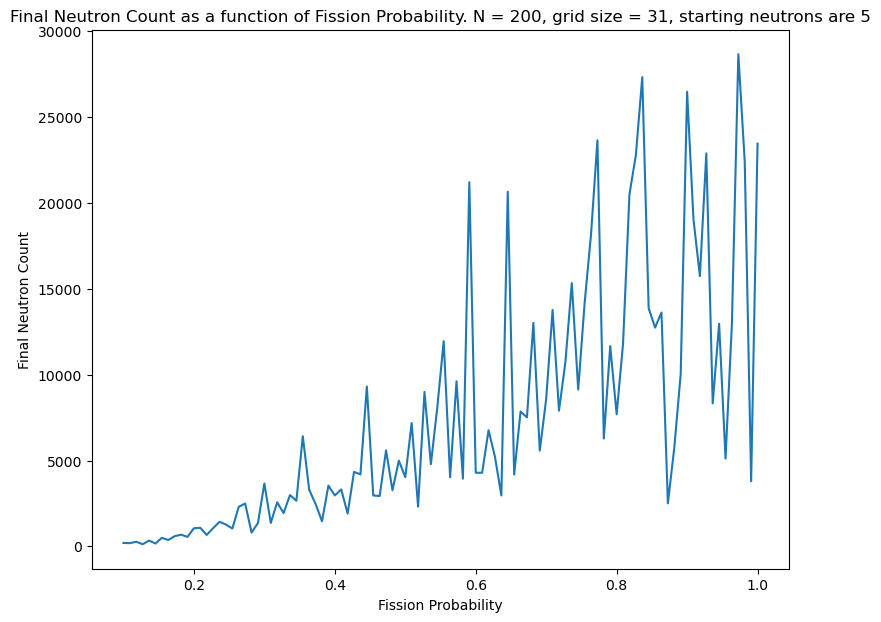

Plotting Time: 113.49603700637817 s


In [420]:
'''Final neutron count as a function of fission probability for fixed simulation conditions'''



fission_probs = np.linspace(0.01, 0.12, 100) 
final_neutron_counts = []



N = 400
size = 31
neutron_count = 30
debug = False



final_iteration_count = a[-1]

start_time = time.time()

for p in fission_probs:
    ttime, n_amounts_recorded, g = run_simulation_with_animation_and_measure_comp_time(neutron_count = neutron_count, size = size, N = N, debug = debug, debug_ani = False, p_fission = p)
    final_iteration_count = n_amounts_recorded[-1]
    final_neutron_counts.append(final_iteration_count)
    
plt.figure(figsize=(9, 7))

plt.plot(fission_probs, final_neutron_counts)
plt.xlabel('Fission Probability')
plt.ylabel('Final Neutron Count')
plt.title(f'Final Neutron Count as a function of Fission Probability. N = {N}, grid size = {size}, starting neutrons are {neutron_count}')
plt.show()

end_time = time.time()

compt_time = end_time - start_time

print(f"Plotting Time: {compt_time} s")


# Computation Times

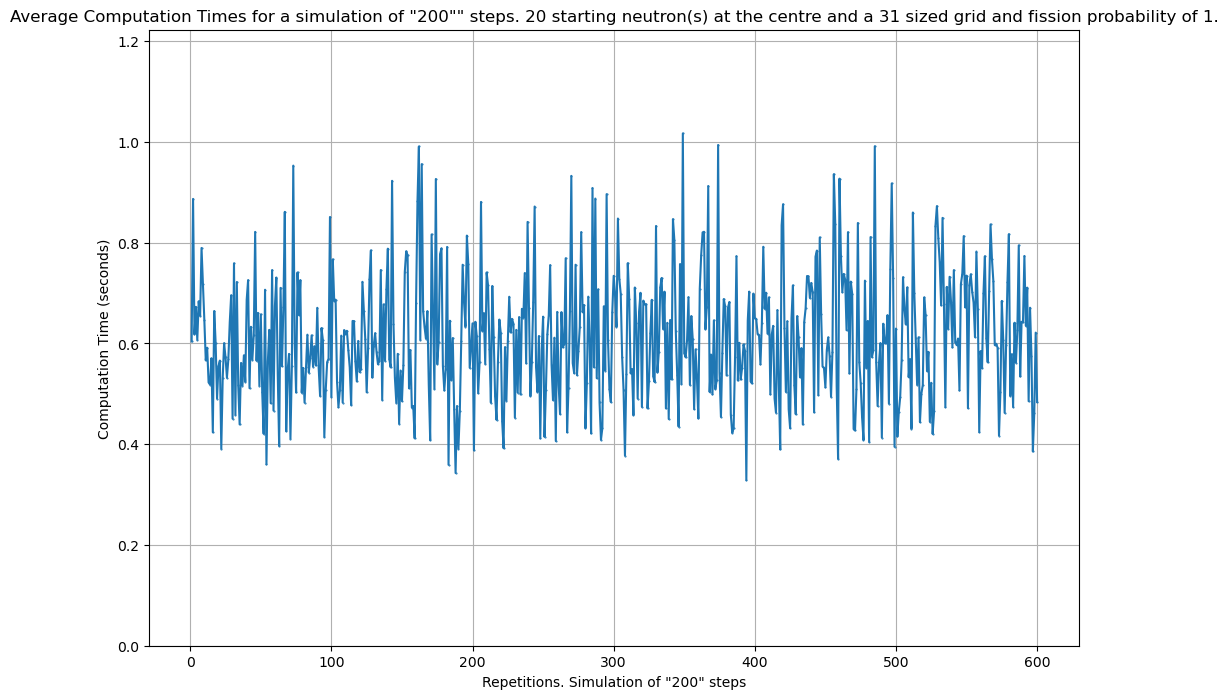

Plotting Time: 0.1882479190826416 s


In [295]:
'''Graph for Average Computation Time for a simulation of N steps. (Non-cumulative computation times)'''

N = 400
size = 31
neutron_count = 30
debug = False
p_fission = 0.065

am_N = 600


comp_times_iterations = []
N_values = np.full(am_N, N)
amount = range(1, am_N + 1, 1)

plt.figure(figsize=(12, 8))


start_time = time.time()

for N in N_values:
    
    comp_time, a, b = run_simulation_with_animation_and_measure_comp_time(neutron_count = neutron_count, size = size, N = N, debug = debug, debug_ani = False, p_fission = p_fission)
    comp_times_iterations.append(comp_time)
    
    

mean = np.mean(comp_times_iterations)

plt.plot(amount, comp_times_iterations, marker='.', markersize='1')
plt.xlabel(f'Repetitions. Simulation of "{N}" steps')
plt.ylabel('Computation Time (seconds)')
plt.ylim(bottom=0, top= mean*2)
plt.title(f'Average Computation Times for a simulation of "{N}" steps. {neutron_count} starting neutron(s) at the centre and a {size} sized grid and fission probability of {p_fission}.')
plt.grid(True)
plt.show()

end_time = time.time()


compt_time = end_time - start_time

print(f"Plotting Time: {compt_time} s")

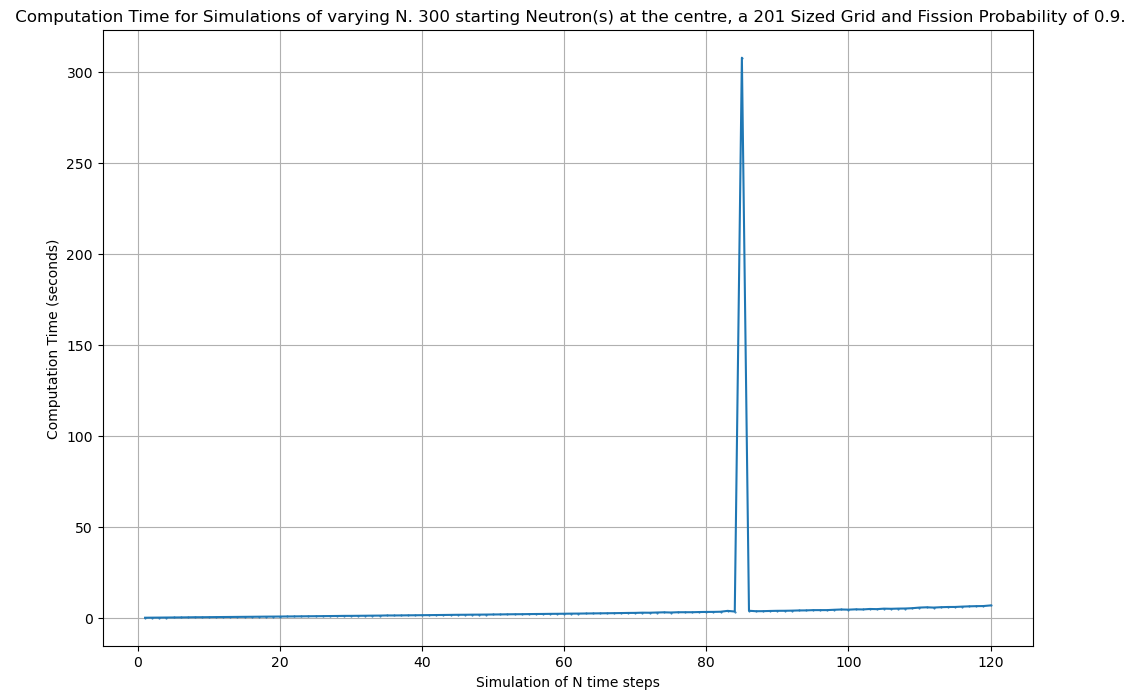

Plotting Time: 616.721107006073 s


In [16]:
'''Computation Time for simulations as a function N

- it shows linearity for N << grid size. Here no neutrons are being leaked.
Supposedly the more amounts of N would mean more neutrons to random walk upon
and non-linearly more computational time. Maybe these effects are not noticeable
given the low final neutron counts in this simulation configuration (around 100), 
implying a sort of neutron linear criticality. Increasing the config to say a 
higher neutroncount = 300 and p_fission = 1.0 may give more criticality. 

- for this, try a config of so, with N = size/2 but for larger N (No neutron leakage)
Here any non-linearity may become more noticeable. 

- alternatively, try include the range where non-linearity is observed due to 
lack of leakage, against the range where leakage become significant ( the amount
of leakage against total must be significant) where N >>> grid size. 






'''



N = 120
size = 201
neutron_count = 300
debug = False
p_fission = 0.9


N_Values = range(1, N+1, 1)

plt.figure(figsize=(12, 8))

comp_times_iterations = []


start_time = time.time()



for N in N_Values:
    comp_time, a, b, s, f, nfission, nleaks = run_simulation_with_animation_and_measure_comp_time(neutron_count = neutron_count, size = size, N = N, debug = debug, debug_ani = False, p_fission = p_fission)
    comp_times_iterations.append(comp_time)
    
    
end_time = time.time()

    

plt.plot(N_Values, comp_times_iterations, marker='.', markersize='1')
plt.xlabel('Simulation of N time steps')
plt.ylabel('Computation Time (seconds)')
plt.title(f' Computation Time for Simulations of varying N. {neutron_count} starting Neutron(s) at the centre, a {size} Sized Grid and Fission Probability of {p_fission}.')
plt.grid(True)
plt.show()

compt_time = end_time - start_time
print(f"Plotting Time: {compt_time} s")

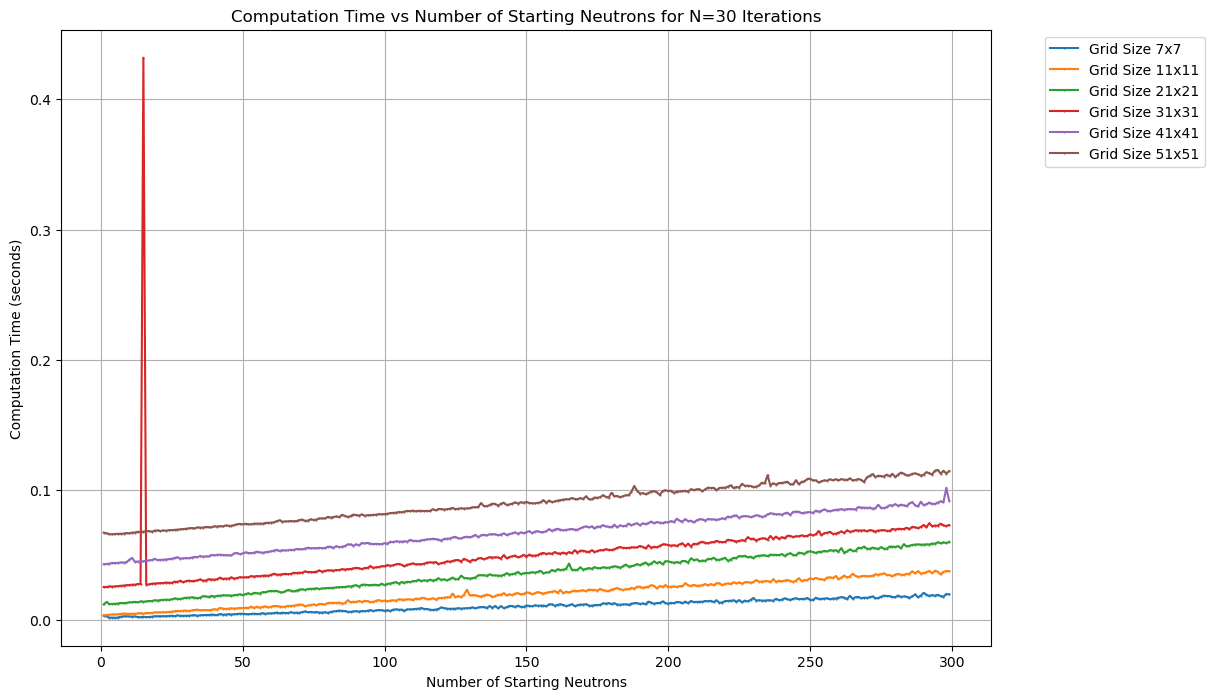

In [494]:
'''Graph for Comp Times as a function of Starting Neutrons. For different grid sizes '''

N = 30
neutron_counts = range(1, 300)  
grid_sizes = [7,11,21,31,41,51] 
debug = False
p_fission = 0.1


comp_times_neutrons = []



comp_times_by_grid_size = {size: [] for size in grid_sizes}

for size in grid_sizes:
    for neutron_count in neutron_counts:
        comp_time_neutron, _, _, s, f = run_simulation_with_animation_and_measure_comp_time(neutron_count, size, N, debug=debug, debug_ani=False, p_fission=p_fission)
        comp_times_by_grid_size[size].append(comp_time_neutron)
        
        
plt.figure(figsize=(12, 8))
    
for size, comp_times in comp_times_by_grid_size.items():
    plt.plot(neutron_counts, comp_times, marker='.', markersize=1, label=f'Grid Size {size}x{size}')   



plt.xlabel('Number of Starting Neutrons')
plt.ylabel('Computation Time (seconds)')
plt.title(f'Computation Time vs Number of Starting Neutrons for N={N} Iterations')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


#same grid, but maybe one with two 51x51: one with N=30 other with N=300
# this would check if the rate at which computation increases for increasing neutron count changes with different different Ns
    

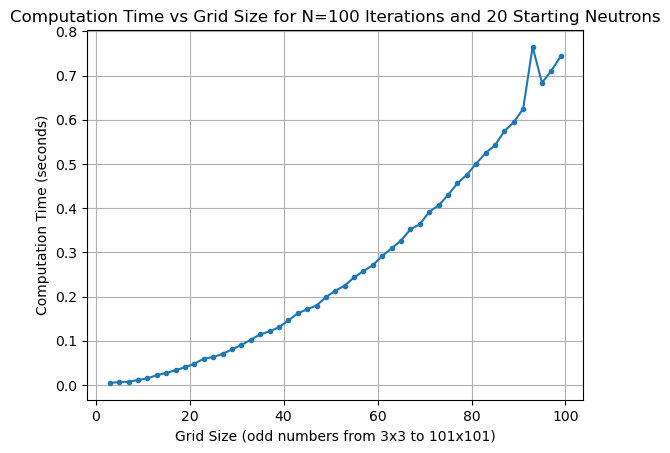

In [305]:
grid_sizes = range(3, 101, 2) 
comp_times_grid = []


N = 100
neutron_count = 20
debug = False
p_fission = 0.1

for size in grid_sizes:
    comp_time, a, b, s, f, nfission, nleaks = run_simulation_with_animation_and_measure_comp_time(neutron_count = neutron_count, size = size, N = N,debug = debug, debug_ani = False, p_fission = p_fission)
    comp_times_grid.append(comp_time)
    
    
plt.plot(grid_sizes, comp_times_grid, marker='.')
plt.xlabel('Grid Size (odd numbers from 3x3 to 101x101)')
plt.ylabel('Computation Time (seconds)')
plt.title(f'Computation Time vs Grid Size for N={N} Iterations and {neutron_count} Starting Neutrons')
plt.grid(True)
plt.show()


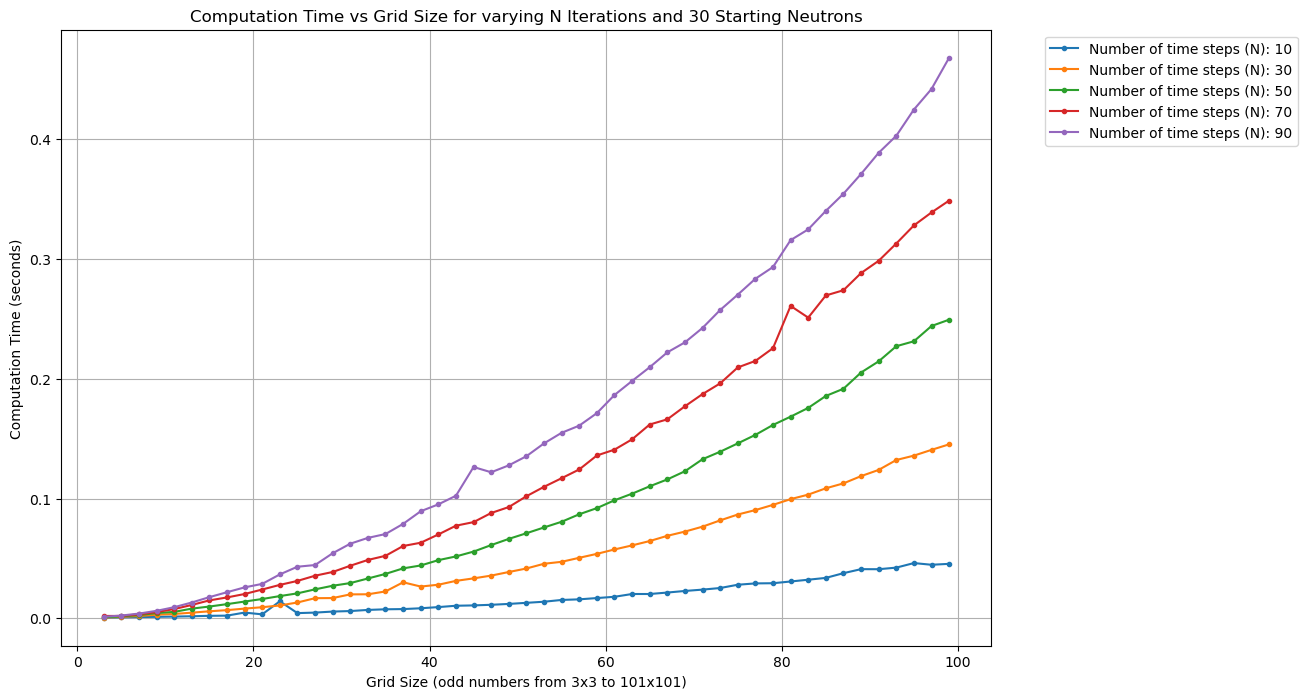

In [533]:
'''Computation Time as a function of Grid Size for varying N Iterations and fixed Starting Neutrons'''


N_range = range(10, 101, 20)
grid_sizes = range(3, 101, 2)
neutron_count = 30
debug = False
p_fission = 0.1


comp_times_by_N = {N_amount: [] for N_amount in N_range}


for N_amount in N_range:
    comp_times_grid = []
    for size in grid_sizes:
        comp_time, _, _, s, f, nfission, nleaks = run_simulation_with_animation_and_measure_comp_time(neutron_count=neutron_count, size=size, N= N_amount, debug=debug, debug_ani=False, p_fission=p_fission)
        comp_times_grid.append(comp_time)
    comp_times_by_N[N_amount] = comp_times_grid

plt.figure(figsize=(12, 8))

for N_amount, comp_times in comp_times_by_N.items():
    plt.plot(grid_sizes, comp_times, marker='.', label=f'Number of time steps (N): {N_amount}')

    
plt.xlabel('Grid Size (odd numbers from 3x3 to 101x101)')
plt.ylabel('Computation Time (seconds)')
plt.title(f'Computation Time vs Grid Size for varying N Iterations and {neutron_count} Starting Neutrons')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


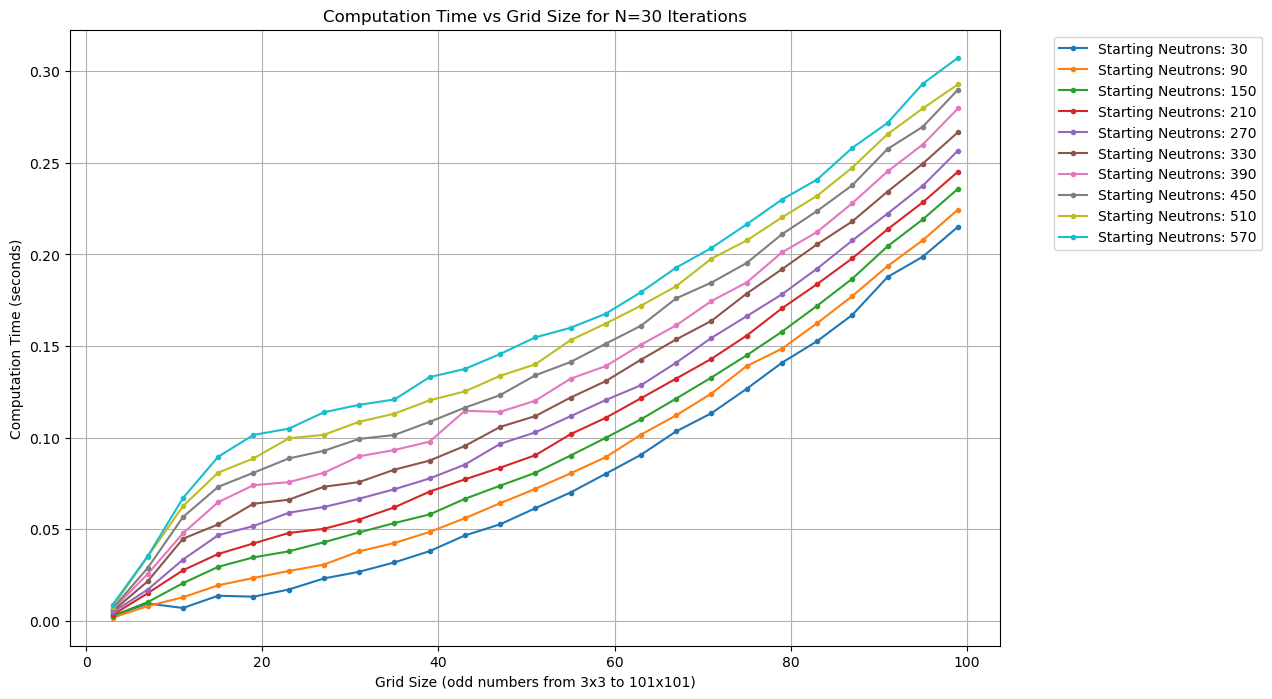

In [439]:
'''Computation Time as a function of Grid Size for varying starting Neutrons amounts, and fixed N'''


starting_neutrons = range(30, 600, 60)
grid_sizes = range(3, 102, 4)
N = 30
debug = False
p_fission = 0.1


comp_times_by_neutron_count = {neutron_count: [] for neutron_count in starting_neutrons}


for neutron_count in starting_neutrons:
    comp_times_grid = []
    for size in grid_sizes:
        comp_time, _, _, s, f = run_simulation_with_animation_and_measure_comp_time(neutron_count=neutron_count, size=size, N=N, debug=debug, debug_ani=False, p_fission= p_fission)
        comp_times_grid.append(comp_time)
    comp_times_by_neutron_count[neutron_count] = comp_times_grid


plt.figure(figsize=(12, 8))
for neutron_count, comp_times in comp_times_by_neutron_count.items():
    plt.plot(grid_sizes, comp_times, marker='.', label=f'Starting Neutrons: {neutron_count}')


    
plt.xlabel('Grid Size (odd numbers from 3x3 to 101x101)')
plt.ylabel('Computation Time (seconds)')
plt.title(f'Computation Time vs Grid Size for N={N} Iterations')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)



### at the start rtracking fewer neutrons
### so less comp time as less neutrons, more grid sizes the neutrons dont leak.
plt.show()


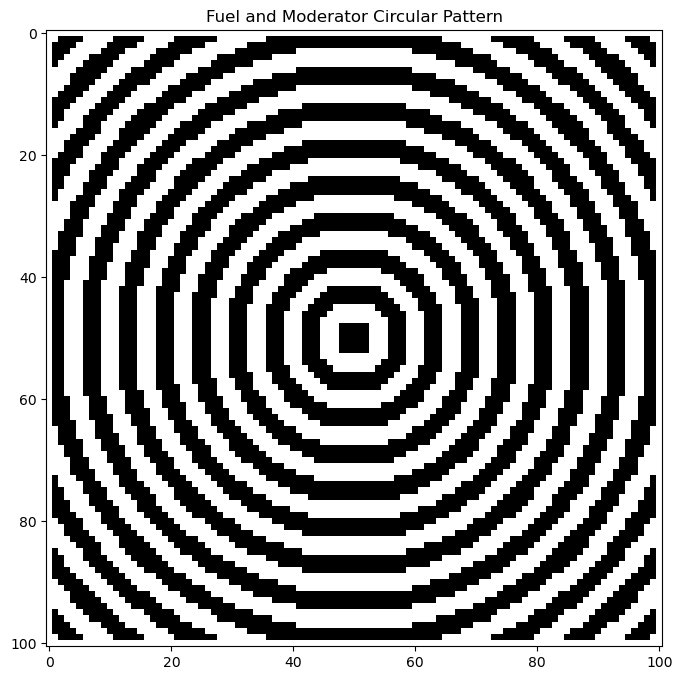

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def create_circular_pattern(grid_size, ring_width=1):
    if grid_size % 2 == 0:
        grid_size += 1  
    
    grid = np.zeros((grid_size, grid_size))

   
    center = grid_size // 2

    
    for i in range(grid_size):
        for j in range(grid_size):
            
            dist = np.sqrt((i - center)**2 + (j - center)**2)
            
        
            if int(dist // ring_width) % 2 == 0:
                grid[i, j] = 1  
            else:
                grid[i, j] = 0  

   
    grid[0, :] = grid[-1, :] = grid[:, 0] = grid[:, -1] = 0

    return grid

grid_size = 101 
ring_width = 3

grid = create_circular_pattern(grid_size, ring_width)

plt.figure(figsize=(8, 8))
plt.imshow(grid, cmap='Greys', interpolation='nearest')
plt.title("Fuel and Moderator Circular Pattern")
plt.show()
